In [1]:
import matplotlib.pyplot as plt
import functools
import numpy as np
import os
import pandas as pd
import random
import re
import skimage
import skimage.io
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.models
from openslide import open_slide, ImageSlide
import cv2
from segmentation_functions import getMask, chooseRandPixel

/project/OSPH/Xiao_lab/shared/yangL/miniconda3/envs/envpytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CLASSES = {"G1", 
           "G2",
           "G3",
           "G4",
           "other"
          }
N_CLASSES = 5
CLASSES_NAMES = ["G1", "G2", "G3", "G4", "other"]

DEVICE = "cuda:1"

In [3]:
# Annotated slides
slide_folder = "/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/pathology_image_data/NLST_ADC/"
slide_names = [_ for _ in os.listdir(slide_folder) if _.endswith(".svs")]
print(len(slide_names))
annotation_names = [_ for _ in os.listdir(slide_folder) if _.endswith(".xml")]
print(len(annotation_names))

mapping_file = "/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/pathology_image_data/NLST_ADC/AACode-Filename-Mapping-curated.csv"
clinical_file = "/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/pathology_image_data/NLST_ADC/nlst_clinical.csv"
survival_file = "/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/pathology_image_data/NLST_ADC/NLST_Survival.csv"

mapping_df = pd.read_csv(mapping_file, index_col=0)
clinical_df = pd.read_csv(clinical_file, index_col=0)
survival_df = pd.read_csv(survival_file, index_col=0)

print(mapping_df)

mapping_df.index = [_.split(" ")[0] for _ in mapping_df.index.values]
mapping_df.index.name = "ID"
clinical_df = clinical_df.merge(mapping_df, left_on = "ID", right_on="ID").merge(survival_df,right_on = "ID",left_on = "ID")
clinical_df["ID"] = clinical_df.index
clinical_df.to_csv('data/nlst_clinical_merged.csv')

345
340
                     filename
aaCode                       
AA00005 0002  NLSI0000002.svs
AA00404 0001  NLSI0000004.svs
AA00404 0002  NLSI0000005.svs
AA00404 0003  NLSI0000006.svs
AA00403 0001  NLSI0000007.svs
...                       ...
AA00342 0002  NLSI0000525.svs
AA00343 0001  NLSI0000526.svs
AA00680 0001         9488.svs
AA00212 0002         9695.svs
AA00211 0003         9697.svs

[1253 rows x 1 columns]


## Calculate pseudotime using PAGA



In [38]:
import scanpy as sc
from matplotlib import rcParams
import anndata as ad
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score


def Norm(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def paga(wsi_df):
    #slide_df = pd.read_csv(wsi_feature_f)
    x, obs = pd.DataFrame(wsi_df.iloc[:,3:]).astype('float64'), pd.DataFrame(wsi_df.iloc[:,0:3])
    adata = ad.AnnData(x,obs)
    
    print('start paga')
    sc.tl.pca(adata, svd_solver='arpack') ## dimension reduction
    sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
    sc.tl.leiden(adata,resolution=1) ## clustering
    sc.tl.paga(adata, groups='leiden') ## PAGA for clustering partition

    #start_class = adata.obs['pred_class'].unique().min()
    start_class = 4
    adata.uns['iroot'] = np.flatnonzero(adata.obs['pred_class']  == start_class)[0] ## set predicted G1 class as root node
    
    sc.tl.dpt(adata)  ### DPT to calculate psudotime
    print('end paga')
    
    
    ## Calculate euclidean distance
    print('start Euclidean')
    coordiantes = adata.obs.sort_values(by="dpt_pseudotime")[["n_col","n_row"]]
    dist =  pd.DataFrame(euclidean_distances(coordiantes,coordiantes))
    dist = Norm(dist[0])
    dist.index, dist.name = coordiantes.index, "Distance"
    adata.obs = adata.obs.join(dist)
    print('end Euclidean')
    
    return adata

def lmreg(adata):
    model = LinearRegression()
    print('start linear regression')
    model.fit(adata.X, adata.obs["Distance"]) 
    pred_dist = model.predict(adata.X)
    residual = adata.obs["Distance"] - pred_dist
    
    #adata.uns['linear_model'] = model
    adata.uns['linear_coef'] = model.coef_
    adata.uns['linear_residual'] = residual.max()
    print( 'end linear ')
    return adata


def lasso(adata, alpha_value= 0.1):
    print('start lasso')
    lasso = Lasso(alpha = alpha_value)
    lasso.fit(adata.X, adata.obs["Distance"])
    pred_dist = lasso.predict(adata.X)
    residual = adata.obs["Distance"] - pred_dist
    
    adata.uns['lasso_residual'] = residual.max()
    adata.uns['lasso_coef'] = lasso.coef_
    #adata.uns['lasso_model'] = lasso
    print('end lasso')
    
    return adata

def get_pairwise_speed(dist, time_f):
    ##input is distance matrix and pseudotime
    speed_df = np.zeros((len(time_f), len(time_f)))
    speed_df[:] = np.nan
    
    for i in dist.index.values:
        #print(i)
        for j in dist.index.values:
            #print(i,j)
            if i != j :
                v = dist.iloc[i,j]/abs(time_f.loc[i,'dpt_pesudotime'] - time_f.loc[j,'dpt_pesudotime'])
            else:
                v = 0
                
            speed_df[i,j] = v
        
    return speed_df


def get_pairwise_speed_rao(dist, time_f):
    ##input is distance matrix and pseudotime
    speed_df = np.zeros((len(time_f), len(time_f)))
    speed_df[:] = np.nan
    
    for i in dist.index.values:
        #print(i)
        for j in dist.index.values:
            #print(i,j)
            v = time_f.loc[i,'dpt_pesudotime'] * time_f.loc[j,'dpt_pesudotime'] * dist.iloc[i,j]
            speed_df[i,j] = v
    
    return speed_df



In [5]:
from tqdm import tqdm
import glob
paga_outdir = "outputs/6_WSI_pseudotime_phikon_224_nlst"
feature_files = glob.glob('./outputs/3_WSI_image_feature_phikon_224_NLST/*.{}'.format('csv'))
print(feature_files [0:1])

for f in tqdm(feature_files):
    #print(f)
    wsi_id = f.split('/')[3]
    print(wsi_id)
    
    #if wsi_id == "11188.svs_248cols_168rows.csv":
        #continue ## this sample runs error when estimating pseudotime

    if os.path.exists(os.path.join(paga_outdir,"{}.h5ad".format(wsi_id))):
        print("Processed")
        continue 
        
    wsi_df = pd.read_csv(f)
    adata =  paga(wsi_df)
    adata = lmreg(adata)
    #adata = lasso(adata, alpha_value= 0.1)
    #adata.obs.to_csv(os.path.join(outdir,"{}_obs.csv".format(wsi_id)),index=False)
    adata.write(os.path.join(paga_outdir,"{}.h5ad".format(wsi_id)), compression="gzip")

['./outputs/3_WSI_image_feature_phikon_224_NLST/10886.svs_260cols_185rows.csv']


 30%|███       | 93/307 [00:00<00:00, 840.79it/s]

10886.svs_260cols_185rows.csv
Processed
11345.svs_274cols_210rows.csv
Processed
9469.svs_284cols_196rows.csv
Processed
10880.svs_265cols_210rows.csv
Processed
10992.svs_245cols_210rows.csv
Processed
10669.svs_245cols_191rows.csv
Processed
10509.svs_202cols_149rows.csv
Processed
11427.svs_245cols_152rows.csv
Processed
10636.svs_147cols_123rows.csv
Processed
9389.svs_171cols_100rows.csv
Processed
11336.svs_207cols_151rows.csv
Processed
11217.svs_147cols_149rows.csv
Processed
9756.svs_238cols_171rows.csv
Processed
NLSI0000198.svs_160cols_99rows.csv
Processed
11185.svs_202cols_194rows.csv
Processed
10865.svs_219cols_158rows.csv
Processed
9972.svs_200cols_109rows.csv
Processed
10380.svs_327cols_224rows.csv
Processed
NLSI0000030.svs_70cols_75rows.csv
Processed
11262.svs_181cols_208rows.csv
Processed
10629.svs_217cols_183rows.csv
Processed
10675.svs_260cols_210rows.csv
Processed
NLSI0000253.svs_155cols_116rows.csv
Processed
11471.svs_260cols_197rows.csv
Processed
NLSI0000136.svs_140cols_91row

100%|██████████| 307/307 [00:00<00:00, 1159.09it/s]

Processed
11358.svs_238cols_191rows.csv
Processed
NLSI0000293.svs_155cols_112rows.csv
Processed
NLSI0000292.svs_160cols_117rows.csv
Processed
NLSI0000143.svs_130cols_107rows.csv
Processed
NLSI0000107.svs_100cols_81rows.csv
Processed
9402.svs_243cols_198rows.csv
Processed
NLSI0000069.svs_155cols_115rows.csv
Processed
11436.svs_202cols_178rows.csv
Processed
10505.svs_281cols_175rows.csv
Processed
10931.svs_217cols_185rows.csv
Processed
9459.svs_250cols_203rows.csv
Processed
NLSI0000185.svs_110cols_88rows.csv
Processed
11295.svs_245cols_193rows.csv
Processed
10862.svs_137cols_142rows.csv
Processed
10997.svs_267cols_184rows.csv
Processed
NLSI0000091.svs_150cols_112rows.csv
Processed
9947.svs_224cols_188rows.csv
Processed
9988.svs_243cols_173rows.csv
Processed
11389.svs_193cols_178rows.csv
Processed
NLSI0000184.svs_115cols_71rows.csv
Processed
11446.svs_221cols_159rows.csv
Processed
9778.svs_286cols_215rows.csv
Processed
11186.svs_207cols_203rows.csv
Processed
NLSI0000039.svs_100cols_90rows

In [9]:
import glob
paga_f = glob.glob('./outputs/6_WSI_pseudotime_phikon_224_nlst/*.{}'.format('h5ad'))
print(paga_f[0:2],len(paga_f))


['./outputs/6_WSI_pseudotime_phikon_224_nlst/10639.svs_229cols_208rows.csv.h5ad', './outputs/6_WSI_pseudotime_phikon_224_nlst/11038.svs_212cols_191rows.csv.h5ad'] 307


## Calculate Speed, Shannon Diversity and Fitness####

In [69]:

adata = ad.read_h5ad(paga_f[0])
print(adata.obs[adata.obs['pred_class'].isin([0,1,2,3])]["pred_class"].value_counts())
adata.obs["pred_class"].value_counts()

pred_class
1    7129
2    5683
0     572
3      26
Name: count, dtype: int64


pred_class
1    7129
4    6294
2    5683
0     572
3      26
Name: count, dtype: int64

In [119]:
import math
from tqdm import tqdm
from scipy.stats import entropy
slides_dict = {}
for key in tqdm(paga_f):
    slide_id = key.split("/")[3]
    print(slide_id)
    n_cols, n_rows = int(slide_id.split("_")[1][:-4]), int(slide_id.split("_")[2].split(".")[0][:-4])
    #print(n_cols, n_rows)

    #11436.svs_202cols_178rows.csv.h5ad
    
    adata = ad.read_h5ad(key)
    shannon_index_all= entropy(adata.obs['pred_class'].value_counts())
    shannon_index_leiden = entropy(adata.obs['leiden'].value_counts())
    shannon_index_tumor = entropy(adata.obs[adata.obs['pred_class'].isin([0,1,2,3])]["pred_class"].value_counts())
    #adata = lmreg(adata)
    #adata = lasso(adata, alpha_value= 0.1)
    
    col_names = ['norm_col', 'norm_row', 'dpt_pesudotime']
    df = pd.DataFrame(columns=col_names)
    df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
    df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
    df['dpt_pesudotime'] = adata.obs.groupby(['leiden','pred_class'])['dpt_pseudotime'].mean()
    df = df.replace([np.inf, -np.inf], np.nan)
    #print(df)
    df = df.dropna(subset=col_names,how='any').reset_index()
    #print(df)
    if not df.empty:
        coordinates = df[["norm_col","norm_row"]]
        dist =  pd.DataFrame(euclidean_distances(coordinates,coordinates))
        #print(dist)
        dist = Norm(dist)
        speed_df, speed_df_rao = get_pairwise_speed(dist, df), get_pairwise_speed_rao(dist, df)
        #print(speed_df)
        speed, speed_rao = pd.DataFrame(speed_df).fillna(0).sum().sum()/len(df), pd.DataFrame(speed_df_rao).fillna(0).sum().sum()/len(df)
        
        
        print(slide_id + ' speed :' + str(speed))
        slide_dict = {}
        slide_dict['Log_Speed'] = math.log(speed) if speed != 0  else 0
        slide_dict['rao_Speed'] = speed_rao
        slide_dict['filename'] = slide_id.split("_")[0]
        slide_dict['shannon_index_all'] = shannon_index_all
        slide_dict['shannon_index_tumor'] = shannon_index_tumor
        slide_dict['shannon_index_leiden'] = shannon_index_leiden
        slide_dict['tissue_ratio'] = len(adata.obs.index)/(n_cols * n_rows)
    
        slides_dict[slide_id] = slide_dict
    #read_dictionary[key]['Speed_rao'] = speed_rao



  0%|          | 0/307 [00:00<?, ?it/s]

10639.svs_229cols_208rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10639.svs_229cols_208rows.csv.h5ad speed :23029.989234064695
11038.svs_212cols_191rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11038.svs_212cols_191rows.csv.h5ad speed :2615.497027586975
11259.svs_128cols_158rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11259.svs_128cols_158rows.csv.h5ad speed :8011.4826888835805
NLSI0000070.svs_95cols_115rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000070.svs_95cols_115rows.csv.h5ad speed :11244.466080659526
NLSI0000231.svs_145cols_117rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000231.svs_145cols_117rows.csv.h5ad speed :6196.3455937629005
11333.svs_267cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11333.svs_267cols_210rows.csv.h5ad speed :8090.729434088473
9980.svs_183cols_100rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9980.svs_183cols_100rows.csv.h5ad speed :8129.162679972028
10126.svs_193cols_200rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10126.svs_193cols_200rows.csv.h5ad speed :12932.198816140564
11433.svs_217cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11433.svs_217cols_210rows.csv.h5ad speed :5776.787651533796
9546.svs_195cols_180rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9546.svs_195cols_180rows.csv.h5ad speed :5922.412939105846
NLSI0000198.svs_160cols_99rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000198.svs_160cols_99rows.csv.h5ad speed :15140.989401868339
10674.svs_164cols_162rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10674.svs_164cols_162rows.csv.h5ad speed :2003.3526290208106
11455.svs_332cols_206rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11455.svs_332cols_206rows.csv.h5ad speed :160801.0086829999
10419.svs_231cols_201rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10419.svs_231cols_201rows.csv.h5ad speed :13726.137564369328
NLSI0000260.svs_140cols_78rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000260.svs_140cols_78rows.csv.h5ad speed :3789.96082710679
9482.svs_260cols_189rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9482.svs_260cols_189rows.csv.h5ad speed :5281.387686148928
10122.svs_217cols_211rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10122.svs_217cols_211rows.csv.h5ad speed :4842.804407661439
9496.svs_260cols_215rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9496.svs_260cols_215rows.csv.h5ad speed :4283.42871750031
9543.svs_313cols_186rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9543.svs_313cols_186rows.csv.h5ad speed :5108.358040152894
11346.svs_332cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11346.svs_332cols_210rows.csv.h5ad speed :5708.693371797355
11460.svs_281cols_209rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11460.svs_281cols_209rows.csv.h5ad speed :3727.1183845543246
NLSI0000157.svs_80cols_71rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000157.svs_80cols_71rows.csv.h5ad speed :6840.567894164291
9665.svs_181cols_136rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9665.svs_181cols_136rows.csv.h5ad speed :5757.736023897508
NLSI0000174.svs_80cols_83rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000174.svs_80cols_83rows.csv.h5ad speed :20868.078762384936
9988.svs_243cols_173rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9988.svs_243cols_173rows.csv.h5ad speed :48148.55642375699
11107.svs_253cols_182rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11107.svs_253cols_182rows.csv.h5ad speed :13431.921657782654
10408.svs_291cols_208rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10408.svs_291cols_208rows.csv.h5ad speed :2658.017249582318
11373.svs_267cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11373.svs_267cols_210rows.csv.h5ad speed :1346.3072779064487
10379.svs_262cols_207rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10379.svs_262cols_207rows.csv.h5ad speed :5215.4854171757825
10629.svs_217cols_183rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10629.svs_217cols_183rows.csv.h5ad speed :45549.798596189925
NLSI0000289.svs_120cols_81rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000289.svs_120cols_81rows.csv.h5ad speed :10315.900748970173
11110.svs_339cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11110.svs_339cols_210rows.csv.h5ad speed :1166.8010370539964
NLSI0000240.svs_130cols_102rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000240.svs_130cols_102rows.csv.h5ad speed :27344.695861080072
10865.svs_219cols_158rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10865.svs_219cols_158rows.csv.h5ad speed :2489.7856478227836
NLSI0000184.svs_115cols_71rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000184.svs_115cols_71rows.csv.h5ad speed :5463.544934368739
11352.svs_260cols_205rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11352.svs_260cols_205rows.csv.h5ad speed :36581.536376158256
NLSI0000068.svs_105cols_87rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000068.svs_105cols_87rows.csv.h5ad speed :43451.217519423226
11247.svs_250cols_199rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11247.svs_250cols_199rows.csv.h5ad speed :4375.098486646181
NLSI0000254.svs_145cols_118rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000254.svs_145cols_118rows.csv.h5ad speed :12536.274857409167
10997.svs_267cols_184rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10997.svs_267cols_184rows.csv.h5ad speed :1013.9537868195307
9754.svs_305cols_203rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9754.svs_305cols_203rows.csv.h5ad speed :26902.1084397887
NLSI0000078.svs_110cols_115rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000078.svs_110cols_115rows.csv.h5ad speed :21255.75228072244
10382.svs_301cols_202rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10382.svs_301cols_202rows.csv.h5ad speed :3729.9847278574325
11357.svs_289cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11357.svs_289cols_210rows.csv.h5ad speed :6364.112909630198
10669.svs_245cols_191rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10669.svs_245cols_191rows.csv.h5ad speed :5750.813538684262
9683.svs_317cols_215rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9683.svs_317cols_215rows.csv.h5ad speed :144225.3899759421
10411.svs_147cols_117rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10411.svs_147cols_117rows.csv.h5ad speed :4334.011869611576
10127.svs_313cols_224rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10127.svs_313cols_224rows.csv.h5ad speed :166337.0160812974
11031.svs_274cols_207rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11031.svs_274cols_207rows.csv.h5ad speed :12340.720104983313
11105.svs_209cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11105.svs_209cols_210rows.csv.h5ad speed :15002.908401852117
NLSI0000126.svs_125cols_101rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000126.svs_125cols_101rows.csv.h5ad speed :17313.923793391372
10878.svs_296cols_206rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10878.svs_296cols_206rows.csv.h5ad speed :6173.509599535985
9459.svs_250cols_203rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9459.svs_250cols_203rows.csv.h5ad speed :15805.79880649019
9946.svs_238cols_215rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9946.svs_238cols_215rows.csv.h5ad speed :26069.2955076969
10380.svs_327cols_224rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10380.svs_327cols_224rows.csv.h5ad speed :37347.639739831095
NLSI0000185.svs_110cols_88rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000185.svs_110cols_88rows.csv.h5ad speed :1370.0060957823575
10851.svs_298cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10851.svs_298cols_210rows.csv.h5ad speed :34705.43746272748
11192.svs_291cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11192.svs_291cols_210rows.csv.h5ad speed :10867.330007413915
11323.svs_269cols_169rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11323.svs_269cols_169rows.csv.h5ad speed :9785.967041326981
11463.svs_135cols_124rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11463.svs_135cols_124rows.csv.h5ad speed :14178.191305480088
9723.svs_236cols_191rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9723.svs_236cols_191rows.csv.h5ad speed :3680.9334690093283
9738.svs_217cols_185rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9738.svs_217cols_185rows.csv.h5ad speed :5049.215546774581
11336.svs_207cols_151rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11336.svs_207cols_151rows.csv.h5ad speed :5259.554129122237
11036.svs_236cols_193rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11036.svs_236cols_193rows.csv.h5ad speed :20022.163012570847
NLSI0000156.svs_115cols_77rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000156.svs_115cols_77rows.csv.h5ad speed :4775.2965355027245
NLSI0000120.svs_150cols_118rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000120.svs_150cols_118rows.csv.h5ad speed :0.0
NLSI0000055.svs_145cols_89rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000055.svs_145cols_89rows.csv.h5ad speed :63317.43624079597
9545.svs_133cols_132rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9545.svs_133cols_132rows.csv.h5ad speed :4402.195042278901
11240.svs_236cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11240.svs_236cols_210rows.csv.h5ad speed :22249.859226528042
10027.svs_87cols_71rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10027.svs_87cols_71rows.csv.h5ad speed :3340.481627161247
10417.svs_219cols_154rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10417.svs_219cols_154rows.csv.h5ad speed :9374.992327307393
NLSI0000293.svs_155cols_112rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000293.svs_155cols_112rows.csv.h5ad speed :13662.44130682081
NLSI0000025.svs_125cols_106rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000025.svs_125cols_106rows.csv.h5ad speed :16407.543454694558
NLSI0000269.svs_155cols_111rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000269.svs_155cols_111rows.csv.h5ad speed :17607.91320167273
11786.svs_80cols_77rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11786.svs_80cols_77rows.csv.h5ad speed :6347.071172775785
NLSI0000166.svs_180cols_114rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000166.svs_180cols_114rows.csv.h5ad speed :44512.358127535284
11458.svs_188cols_157rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11458.svs_188cols_157rows.csv.h5ad speed :12408.236725410348
9530.svs_356cols_215rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9530.svs_356cols_215rows.csv.h5ad speed :14623.84960024629
10499.svs_171cols_155rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10499.svs_171cols_155rows.csv.h5ad speed :60606.72466030014
11438.svs_293cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11438.svs_293cols_210rows.csv.h5ad speed :5959.38017956644
10506.svs_248cols_181rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10506.svs_248cols_181rows.csv.h5ad speed :30942.31765127012
11368.svs_260cols_194rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11368.svs_260cols_194rows.csv.h5ad speed :30252.620702927714
11454.svs_241cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11454.svs_241cols_210rows.csv.h5ad speed :26750.190376062055
9993.svs_286cols_213rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9993.svs_286cols_213rows.csv.h5ad speed :21135.191620695554
11127.svs_248cols_187rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11127.svs_248cols_187rows.csv.h5ad speed :7971.034444541742
NLSI0000277.svs_105cols_86rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000277.svs_105cols_86rows.csv.h5ad speed :15188.032383842283
10131.svs_238cols_201rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10131.svs_238cols_201rows.csv.h5ad speed :4342.145159964986
10378.svs_224cols_185rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10378.svs_224cols_185rows.csv.h5ad speed :6900.244782096344
11249.svs_221cols_160rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11249.svs_221cols_160rows.csv.h5ad speed :28094.900463534075
9388.svs_281cols_177rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9388.svs_281cols_177rows.csv.h5ad speed :7863.30702336814
10500.svs_329cols_198rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10500.svs_329cols_198rows.csv.h5ad speed :8881.940038311312
11262.svs_181cols_208rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11262.svs_181cols_208rows.csv.h5ad speed :8496.744257121883
9706.svs_277cols_206rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9706.svs_277cols_206rows.csv.h5ad speed :3787.2200065792363
11295.svs_245cols_193rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11295.svs_245cols_193rows.csv.h5ad speed :6596.075116121087
10995.svs_238cols_196rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10995.svs_238cols_196rows.csv.h5ad speed :2417.7706176606257
11286.svs_291cols_203rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11286.svs_291cols_203rows.csv.h5ad speed :18629.59977974705
9776.svs_253cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9776.svs_253cols_210rows.csv.h5ad speed :9477.380940809535
9701.svs_212cols_205rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9701.svs_212cols_205rows.csv.h5ad speed :3309.493204110852
NLSI0000152.svs_115cols_76rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000152.svs_115cols_76rows.csv.h5ad speed :3159.3411973523
NLSI0000091.svs_150cols_112rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000091.svs_150cols_112rows.csv.h5ad speed :37437.10553089613
11113.svs_135cols_170rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11113.svs_135cols_170rows.csv.h5ad speed :7934.597556355663
11361.svs_286cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11361.svs_286cols_210rows.csv.h5ad speed :4243.736933473766
11377.svs_130cols_131rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11377.svs_130cols_131rows.csv.h5ad speed :1667.154181395598
NLSI0000086.svs_155cols_105rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000086.svs_155cols_105rows.csv.h5ad speed :0.0
NLSI0000023.svs_145cols_95rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000023.svs_145cols_95rows.csv.h5ad speed :7286.784090821892
10880.svs_265cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10880.svs_265cols_210rows.csv.h5ad speed :1911.5639000493045
11429.svs_130cols_176rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11429.svs_130cols_176rows.csv.h5ad speed :30636.264154098088
9462.svs_183cols_151rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9462.svs_183cols_151rows.csv.h5ad speed :1862.509531005958
11253.svs_212cols_185rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11253.svs_212cols_185rows.csv.h5ad speed :2799.515803264481
10024.svs_53cols_45rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10024.svs_53cols_45rows.csv.h5ad speed :3714.7440277277638
NLSI0000101.svs_130cols_105rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000101.svs_130cols_105rows.csv.h5ad speed :57137.89354417336
9481.svs_243cols_176rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9481.svs_243cols_176rows.csv.h5ad speed :30206.580441703234
10992.svs_245cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10992.svs_245cols_210rows.csv.h5ad speed :5685.633959552896
10939.svs_277cols_209rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10939.svs_277cols_209rows.csv.h5ad speed :5951.463759769752
NLSI0000292.svs_160cols_117rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000292.svs_160cols_117rows.csv.h5ad speed :33067.64897738534
9460.svs_255cols_187rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9460.svs_255cols_187rows.csv.h5ad speed :8910.330643395198
10619.svs_169cols_169rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10619.svs_169cols_169rows.csv.h5ad speed :5566.86236679855
10374.svs_334cols_188rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10374.svs_334cols_188rows.csv.h5ad speed :1663.4639750337342
11279.svs_188cols_196rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11279.svs_188cols_196rows.csv.h5ad speed :8104.058988875773
10862.svs_137cols_142rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10862.svs_137cols_142rows.csv.h5ad speed :758.6849956231285
11128.svs_245cols_175rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11128.svs_245cols_175rows.csv.h5ad speed :11930.057529389203
11217.svs_147cols_149rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11217.svs_147cols_149rows.csv.h5ad speed :4722.685225362808
11391.svs_169cols_190rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11391.svs_169cols_190rows.csv.h5ad speed :6679.303517432674
10860.svs_260cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10860.svs_260cols_210rows.csv.h5ad speed :27985.03880280082
10903.svs_293cols_205rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10903.svs_293cols_205rows.csv.h5ad speed :4041.9319714500607
NLSI0000154.svs_145cols_91rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000154.svs_145cols_91rows.csv.h5ad speed :15290.049402448254
NLSI0000039.svs_100cols_90rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000039.svs_100cols_90rows.csv.h5ad speed :109624.35420563283
9990.svs_308cols_205rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9990.svs_308cols_205rows.csv.h5ad speed :66599.0537070242
11218.svs_245cols_160rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11218.svs_245cols_160rows.csv.h5ad speed :13884.091015660091
NLSI0000291.svs_135cols_106rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000291.svs_135cols_106rows.csv.h5ad speed :4278.863609161371
11229.svs_291cols_189rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11229.svs_291cols_189rows.csv.h5ad speed :20705.527563552918
11471.svs_260cols_197rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11471.svs_260cols_197rows.csv.h5ad speed :72671.26850925536
11432.svs_188cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11432.svs_188cols_210rows.csv.h5ad speed :8640.450481666152
9756.svs_238cols_171rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9756.svs_238cols_171rows.csv.h5ad speed :26343.333166739474
10640.svs_185cols_185rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10640.svs_185cols_185rows.csv.h5ad speed :27836.670632142945
NLSI0000029.svs_135cols_110rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000029.svs_135cols_110rows.csv.h5ad speed :83745.81347710417
11296.svs_238cols_170rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11296.svs_238cols_170rows.csv.h5ad speed :4883.895279095935
9966.svs_286cols_209rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9966.svs_286cols_209rows.csv.h5ad speed :36038.966483234275
10988.svs_181cols_167rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10988.svs_181cols_167rows.csv.h5ad speed :3457.911819032828
11788.svs_303cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11788.svs_303cols_210rows.csv.h5ad speed :7831.7739036479925
11334.svs_217cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11334.svs_217cols_210rows.csv.h5ad speed :1185.4921498487986
NLSI0000111.svs_135cols_99rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000111.svs_135cols_99rows.csv.h5ad speed :3482.7139251659605
10894.svs_197cols_201rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10894.svs_197cols_201rows.csv.h5ad speed :6866.627336365723
9778.svs_286cols_215rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9778.svs_286cols_215rows.csv.h5ad speed :29581.99054894648
10484.svs_200cols_183rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10484.svs_200cols_183rows.csv.h5ad speed :13554.846930535137
NLSI0000259.svs_150cols_65rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000259.svs_150cols_65rows.csv.h5ad speed :62588.54246482327
11326.svs_229cols_208rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11326.svs_229cols_208rows.csv.h5ad speed :1539.7128175218672
11030.svs_291cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11030.svs_291cols_210rows.csv.h5ad speed :31344.51424253698
10420.svs_236cols_163rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10420.svs_236cols_163rows.csv.h5ad speed :14258.055865358385
9813.svs_181cols_212rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9813.svs_181cols_212rows.csv.h5ad speed :12410.262926757929
9548.svs_190cols_187rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9548.svs_190cols_187rows.csv.h5ad speed :8993.858852051435
10025.svs_188cols_198rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10025.svs_188cols_198rows.csv.h5ad speed :7394.970916368883
10872.svs_164cols_158rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10872.svs_164cols_158rows.csv.h5ad speed :10393.527965543553
10901.svs_157cols_131rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10901.svs_157cols_131rows.csv.h5ad speed :1022.0748422211063
10492.svs_169cols_194rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10492.svs_169cols_194rows.csv.h5ad speed :45358.22846955519
9747.svs_370cols_215rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9747.svs_370cols_215rows.csv.h5ad speed :inf
9684.svs_308cols_215rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9684.svs_308cols_215rows.csv.h5ad speed :18222.443701464133
11321.svs_257cols_193rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11321.svs_257cols_193rows.csv.h5ad speed :8221.294575556834
10171.svs_164cols_105rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10171.svs_164cols_105rows.csv.h5ad speed :7960.044592310017
10460.svs_286cols_224rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10460.svs_286cols_224rows.csv.h5ad speed :25004.051995005128
NLSI0000104.svs_130cols_89rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000104.svs_130cols_89rows.csv.h5ad speed :4692.74946710449
9401.svs_159cols_178rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9401.svs_159cols_178rows.csv.h5ad speed :1458.029296302241
NLSI0000077.svs_140cols_98rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000077.svs_140cols_98rows.csv.h5ad speed :20352.113625562382
11191.svs_303cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11191.svs_303cols_210rows.csv.h5ad speed :15421.173793387874
9692.svs_308cols_215rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9692.svs_308cols_215rows.csv.h5ad speed :5343.688832840441
11389.svs_193cols_178rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11389.svs_193cols_178rows.csv.h5ad speed :3702.1485130037468
10886.svs_260cols_185rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10886.svs_260cols_185rows.csv.h5ad speed :3885.8041145598986
NLSI0000030.svs_70cols_75rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000030.svs_70cols_75rows.csv.h5ad speed :8846.198992768846
9469.svs_284cols_196rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9469.svs_284cols_196rows.csv.h5ad speed :4990.67286130721
9757.svs_197cols_188rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9757.svs_197cols_188rows.csv.h5ad speed :14711.150946593358
9707.svs_238cols_194rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9707.svs_238cols_194rows.csv.h5ad speed :6124.1830944482645
NLSI0000267.svs_155cols_105rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000267.svs_155cols_105rows.csv.h5ad speed :131551.04023151382
10136.svs_142cols_163rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10136.svs_142cols_163rows.csv.h5ad speed :4024.9899248430024
9497.svs_248cols_209rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9497.svs_248cols_209rows.csv.h5ad speed :3127.2360769907054
9965.svs_243cols_177rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9965.svs_243cols_177rows.csv.h5ad speed :2708.0862185525866
9550.svs_277cols_202rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9550.svs_277cols_202rows.csv.h5ad speed :12335.792644773243
11364.svs_238cols_168rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11364.svs_238cols_168rows.csv.h5ad speed :4591.501266198825
11186.svs_207cols_203rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11186.svs_207cols_203rows.csv.h5ad speed :2926.9534550054823
NLSI0000131.svs_140cols_95rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000131.svs_140cols_95rows.csv.h5ad speed :7366.450760139217
NLSI0000134.svs_145cols_74rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000134.svs_145cols_74rows.csv.h5ad speed :4336.8445349351305
NLSI0000197.svs_145cols_94rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000197.svs_145cols_94rows.csv.h5ad speed :6621.962364128423
11427.svs_245cols_152rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11427.svs_245cols_152rows.csv.h5ad speed :4579.531786334499
11185.svs_202cols_194rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11185.svs_202cols_194rows.csv.h5ad speed :15782.43331291093
11313.svs_185cols_127rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11313.svs_185cols_127rows.csv.h5ad speed :3979.1851911800454
9475.svs_241cols_205rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9475.svs_241cols_205rows.csv.h5ad speed :12322.238775232088
9947.svs_224cols_188rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9947.svs_224cols_188rows.csv.h5ad speed :3579.29155328721
10443.svs_221cols_224rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10443.svs_221cols_224rows.csv.h5ad speed :4395.366765139847
9746.svs_267cols_209rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9746.svs_267cols_209rows.csv.h5ad speed :25166.366837551443
10384.svs_137cols_109rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10384.svs_137cols_109rows.csv.h5ad speed :3683.167389770574
NLSI0000155.svs_130cols_77rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000155.svs_130cols_77rows.csv.h5ad speed :5981.704979302195
10381.svs_226cols_204rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10381.svs_226cols_204rows.csv.h5ad speed :4379.634151396181
11033.svs_212cols_152rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11033.svs_212cols_152rows.csv.h5ad speed :6983.222509394389
10497.svs_181cols_192rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10497.svs_181cols_192rows.csv.h5ad speed :3536.5607335345458
NLSI0000151.svs_125cols_83rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000151.svs_125cols_83rows.csv.h5ad speed :3934.482033037626
9740.svs_281cols_215rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9740.svs_281cols_215rows.csv.h5ad speed :5991.632551226017
9390.svs_301cols_215rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9390.svs_301cols_215rows.csv.h5ad speed :5115.516403774297
NLSI0000026.svs_105cols_98rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000026.svs_105cols_98rows.csv.h5ad speed :13907.961235622262
9689.svs_229cols_155rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9689.svs_229cols_155rows.csv.h5ad speed :11255.896222556956
10931.svs_217cols_185rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10931.svs_217cols_185rows.csv.h5ad speed :138847.70112883355
11122.svs_243cols_158rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11122.svs_243cols_158rows.csv.h5ad speed :1168.6368309682073
NLSI0000136.svs_140cols_91rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000136.svs_140cols_91rows.csv.h5ad speed :3631.4039198276155
11312.svs_226cols_127rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11312.svs_226cols_127rows.csv.h5ad speed :8341.868506477816
11388.svs_178cols_190rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11388.svs_178cols_190rows.csv.h5ad speed :3369.881654930973
11462.svs_272cols_173rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11462.svs_272cols_173rows.csv.h5ad speed :3309.5503977251274
9737.svs_221cols_186rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9737.svs_221cols_186rows.csv.h5ad speed :2958.8513815999722
11358.svs_238cols_191rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11358.svs_238cols_191rows.csv.h5ad speed :17978.69257398865
10503.svs_236cols_224rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10503.svs_236cols_224rows.csv.h5ad speed :7150.710101826025
10999.svs_267cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10999.svs_267cols_210rows.csv.h5ad speed :4508.254389419526
11345.svs_274cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11345.svs_274cols_210rows.csv.h5ad speed :12195.769849060078
NLSI0000143.svs_130cols_107rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000143.svs_130cols_107rows.csv.h5ad speed :28512.054055303634
9544.svs_265cols_215rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9544.svs_265cols_215rows.csv.h5ad speed :6391.505754870111
11248.svs_269cols_193rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11248.svs_269cols_193rows.csv.h5ad speed :4258.932644189504
NLSI0000100.svs_50cols_62rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000100.svs_50cols_62rows.csv.h5ad speed :567.942119854961
11351.svs_277cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11351.svs_277cols_210rows.csv.h5ad speed :9251.550000229352
9468.svs_241cols_158rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9468.svs_241cols_158rows.csv.h5ad speed :10901.026116934143
NLSI0000224.svs_105cols_105rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000224.svs_105cols_105rows.csv.h5ad speed :12248.86734496806
NLSI0000105.svs_45cols_34rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000105.svs_45cols_34rows.csv.h5ad speed :25475.84262589923
10989.svs_207cols_168rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10989.svs_207cols_168rows.csv.h5ad speed :39761.62007007084
10994.svs_269cols_143rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10994.svs_269cols_143rows.csv.h5ad speed :3078.190648980723
9549.svs_257cols_215rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9549.svs_257cols_215rows.csv.h5ad speed :24886.013631062222
10998.svs_317cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10998.svs_317cols_210rows.csv.h5ad speed :2388.4998659013086
9741.svs_322cols_215rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9741.svs_322cols_215rows.csv.h5ad speed :4631.815119999975
11446.svs_221cols_159rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11446.svs_221cols_159rows.csv.h5ad speed :16719.97312113882
NLSI0000045.svs_135cols_78rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000045.svs_135cols_78rows.csv.h5ad speed :2358.9966573588054
10401.svs_272cols_205rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10401.svs_272cols_205rows.csv.h5ad speed :27012.61157326701
NLSI0000046.svs_155cols_111rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000046.svs_155cols_111rows.csv.h5ad speed :61683.38275100864
11436.svs_202cols_178rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11436.svs_202cols_178rows.csv.h5ad speed :3170.295663720744
11372.svs_267cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11372.svs_267cols_210rows.csv.h5ad speed :22450.677048584443
11398.svs_293cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11398.svs_293cols_210rows.csv.h5ad speed :4420.4706767557545
11293.svs_221cols_175rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11293.svs_221cols_175rows.csv.h5ad speed :20276.66122348095
NLSI0000098.svs_100cols_102rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000098.svs_100cols_102rows.csv.h5ad speed :38230.15719240616
11280.svs_169cols_206rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11280.svs_169cols_206rows.csv.h5ad speed :5986.912612066177
NLSI0000090.svs_130cols_99rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000090.svs_130cols_99rows.csv.h5ad speed :215623.07635920838
NLSI0000186.svs_115cols_81rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000186.svs_115cols_81rows.csv.h5ad speed :49322.32258006784
10409.svs_349cols_204rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10409.svs_349cols_204rows.csv.h5ad speed :36262.64096738892
NLSI0000024.svs_125cols_84rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000024.svs_125cols_84rows.csv.h5ad speed :21814.911198134974
10876.svs_313cols_209rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10876.svs_313cols_209rows.csv.h5ad speed :50747.006813467204
10887.svs_274cols_196rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10887.svs_274cols_196rows.csv.h5ad speed :10537.756081438825
NLSI0000227.svs_120cols_85rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000227.svs_120cols_85rows.csv.h5ad speed :13805.133676091984
10675.svs_260cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10675.svs_260cols_210rows.csv.h5ad speed :3716.4613130022217
11043.svs_301cols_202rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11043.svs_301cols_202rows.csv.h5ad speed :3804.300458184465
10461.svs_289cols_223rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10461.svs_289cols_223rows.csv.h5ad speed :10431.0312203684
NLSI0000270.svs_120cols_119rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000270.svs_120cols_119rows.csv.h5ad speed :38778.71639956619
11042.svs_327cols_205rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11042.svs_327cols_205rows.csv.h5ad speed :126098.35641570922
NLSI0000083.svs_100cols_83rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000083.svs_100cols_83rows.csv.h5ad speed :15440.374613431932
11233.svs_250cols_205rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11233.svs_250cols_205rows.csv.h5ad speed :3851.038859737839
11004.svs_317cols_202rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11004.svs_317cols_202rows.csv.h5ad speed :2942.1730851164807
10508.svs_250cols_198rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10508.svs_250cols_198rows.csv.h5ad speed :22920.1843731297
11342.svs_116cols_176rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11342.svs_116cols_176rows.csv.h5ad speed :8465.68358933562
11456.svs_197cols_186rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11456.svs_197cols_186rows.csv.h5ad speed :2069.1050642375585
NLSI0000015.svs_135cols_77rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000015.svs_135cols_77rows.csv.h5ad speed :1.7803470342699392
11787.svs_349cols_203rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11787.svs_349cols_203rows.csv.h5ad speed :1899.718229082939
10905.svs_277cols_206rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10905.svs_277cols_206rows.csv.h5ad speed :9225.21072319284
11435.svs_298cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11435.svs_298cols_210rows.csv.h5ad speed :7826.922512493076
10987.svs_197cols_160rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10987.svs_197cols_160rows.csv.h5ad speed :8054.241634946255
11048.svs_286cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11048.svs_286cols_210rows.csv.h5ad speed :36174.95616218862
11112.svs_169cols_164rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11112.svs_169cols_164rows.csv.h5ad speed :1927.7890800790879
11234.svs_277cols_193rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11234.svs_277cols_193rows.csv.h5ad speed :15922.622086635269
9972.svs_200cols_109rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9972.svs_200cols_109rows.csv.h5ad speed :20878.393051269577
10505.svs_281cols_175rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10505.svs_281cols_175rows.csv.h5ad speed :12619.588381432484
NLSI0000107.svs_100cols_81rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000107.svs_100cols_81rows.csv.h5ad speed :44004.99977814848
NLSI0000075.svs_105cols_97rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000075.svs_105cols_97rows.csv.h5ad speed :14454.820141658769
10400.svs_248cols_159rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10400.svs_248cols_159rows.csv.h5ad speed :25914.07860417054
10128.svs_178cols_57rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10128.svs_178cols_57rows.csv.h5ad speed :11216.017742494952
NLSI0000110.svs_145cols_95rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000110.svs_145cols_95rows.csv.h5ad speed :6235.526116217494
10046.svs_257cols_214rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10046.svs_257cols_214rows.csv.h5ad speed :7366.729888879474
10485.svs_238cols_171rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10485.svs_238cols_171rows.csv.h5ad speed :16753.650101052528
9532.svs_358cols_215rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9532.svs_358cols_215rows.csv.h5ad speed :16462.530782060225
10938.svs_260cols_177rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10938.svs_260cols_177rows.csv.h5ad speed :6242.706746354536
NLSI0000069.svs_155cols_115rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000069.svs_155cols_115rows.csv.h5ad speed :150967.56946324898
9463.svs_260cols_180rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9463.svs_260cols_180rows.csv.h5ad speed :3995.8490356465854
11003.svs_267cols_184rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11003.svs_267cols_184rows.csv.h5ad speed :7258.007258367784
9777.svs_272cols_215rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9777.svs_272cols_215rows.csv.h5ad speed :42755.51600603422
10514.svs_217cols_196rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10514.svs_217cols_196rows.csv.h5ad speed :8901.654089912166
11188.svs_310cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11188.svs_310cols_210rows.csv.h5ad speed :16896.725393215685
NLSI0000290.svs_130cols_96rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000290.svs_130cols_96rows.csv.h5ad speed :20303.117770931956
9529.svs_265cols_205rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9529.svs_265cols_205rows.csv.h5ad speed :10982.111520123524
NLSI0000161.svs_145cols_87rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000161.svs_145cols_87rows.csv.h5ad speed :4791.530553112842
10904.svs_269cols_209rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10904.svs_269cols_209rows.csv.h5ad speed :3761.500029264584
9461.svs_147cols_77rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9461.svs_147cols_77rows.csv.h5ad speed :2399.3655393021536
NLSI0000132.svs_175cols_114rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000132.svs_175cols_114rows.csv.h5ad speed :12934.500547408175
11005.svs_277cols_205rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11005.svs_277cols_205rows.csv.h5ad speed :3775.268506591624
9808.svs_291cols_214rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9808.svs_291cols_214rows.csv.h5ad speed :59949.26723684801
10620.svs_265cols_215rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10620.svs_265cols_215rows.csv.h5ad speed :3518.067991894176
11010.svs_209cols_182rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11010.svs_209cols_182rows.csv.h5ad speed :16711.57633904855
11252.svs_70cols_65rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11252.svs_70cols_65rows.csv.h5ad speed :139466.5587905173
11292.svs_193cols_190rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11292.svs_193cols_190rows.csv.h5ad speed :8656.950516342065
10881.svs_281cols_194rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10881.svs_281cols_194rows.csv.h5ad speed :4046.1269370737105
9402.svs_243cols_198rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9402.svs_243cols_198rows.csv.h5ad speed :4896.654510144106
10130.svs_274cols_224rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10130.svs_274cols_224rows.csv.h5ad speed :128838.70121723521
10509.svs_202cols_149rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10509.svs_202cols_149rows.csv.h5ad speed :16155.677618125072
10028.svs_154cols_92rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10028.svs_154cols_92rows.csv.h5ad speed :19988.50133415052
9967.svs_241cols_192rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9967.svs_241cols_192rows.csv.h5ad speed :64233.87296592456
10837.svs_197cols_178rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10837.svs_197cols_178rows.csv.h5ad speed :21517.342323323574
9389.svs_171cols_100rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9389.svs_171cols_100rows.csv.h5ad speed :9442.767922232066
11106.svs_171cols_196rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11106.svs_171cols_196rows.csv.h5ad speed :3358.3381994629954
NLSI0000294.svs_135cols_78rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000294.svs_135cols_78rows.csv.h5ad speed :3470.8926882494898
10494.svs_171cols_123rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10494.svs_171cols_123rows.csv.h5ad speed :40850.83548723039
11445.svs_221cols_208rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

11445.svs_221cols_208rows.csv.h5ad speed :1224.3382829249542
10636.svs_147cols_123rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10636.svs_147cols_123rows.csv.h5ad speed :807.3926973185593
9465.svs_207cols_180rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9465.svs_207cols_180rows.csv.h5ad speed :45448.8325952376
10504.svs_106cols_75rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10504.svs_106cols_75rows.csv.h5ad speed :707.9410130918662
9474.svs_248cols_153rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

9474.svs_248cols_153rows.csv.h5ad speed :9417.387443469577
NLSI0000253.svs_155cols_116rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000253.svs_155cols_116rows.csv.h5ad speed :8349.642405596574
10934.svs_229cols_168rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10934.svs_229cols_168rows.csv.h5ad speed :5083.5923198905875
NLSI0000229.svs_95cols_106rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

NLSI0000229.svs_95cols_106rows.csv.h5ad speed :36207.03599840299
10877.svs_346cols_210rows.csv.h5ad


/tmp/ipykernel_291422/3061493562.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_col'] = adata.obs.groupby(['leiden','pred_class'])['n_col'].mean()/n_cols
/tmp/ipykernel_291422/3061493562.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['norm_row'] = adata.obs.groupby(['leiden','pred_class'])['n_row'].mean()/n_rows
/tmp/ipykernel_291422/3061493562.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  

10877.svs_346cols_210rows.csv.h5ad speed :5439.647717518793


In [120]:
pd.DataFrame(slides_dict).T

,Log_Speed,rao_Speed,filename,shannon_index_all,shannon_index_tumor,shannon_index_leiden,tissue_ratio
10639.svs_229cols_208rows.csv.h5ad,10.044553,1.209956,10639.svs,1.202468,0.846392,3.267118,0.413671
11038.svs_212cols_191rows.csv.h5ad,7.869209,5.18383,11038.svs,0.665301,0.201032,3.510597,0.582485
11259.svs_128cols_158rows.csv.h5ad,8.988631,9.233121,11259.svs,1.21928,1.065766,3.213687,0.6161
NLSI0000070.svs_95cols_115rows.csv.h5ad,9.327631,10.625834,NLSI0000070.svs,0.657771,0.366555,3.130358,0.553684
NLSI0000231.svs_145cols_117rows.csv.h5ad,8.731715,4.074367,NLSI0000231.svs,0.856814,0.749805,3.226174,0.492367
...,...,...,...,...,...,...,...
9474.svs_248cols_153rows.csv.h5ad,9.150313,0.395053,9474.svs,1.161802,0.793729,3.348059,0.591925
NLSI0000253.svs_155cols_116rows.csv.h5ad,9.029974,0.905104,NLSI0000253.svs,1.070826,0.664181,3.196347,0.612013
10934.svs_229cols_168rows.csv.h5ad,8.533773,22.132325,10934.svs,1.327731,1.073065,3.201744,0.511749
NLSI0000229.svs_95cols_106rows.csv.h5ad,10.497009,15.05627,NLSI0000229.svs,1.06874,0.929285,3.1722,0.636842


In [4]:
paga_outdir = './outputs/6_WSI_pseudotime_phikon_224_nlst'
#np.save(os.path.join(paga_outdir,"slides_metrics_normdist.npy"), slides_dict)
slides_dict = np.load(os.path.join(paga_outdir,"slides_metrics_normdist.npy"), allow_pickle=True)
pd.DataFrame(slides_dict.item()).T


,Log_Speed,rao_Speed,filename,shannon_index_all,shannon_index_tumor,shannon_index_leiden,tissue_ratio
10639.svs_229cols_208rows.csv.h5ad,10.044553,1.209956,10639.svs,1.202468,0.846392,3.267118,0.413671
11038.svs_212cols_191rows.csv.h5ad,7.869209,5.18383,11038.svs,0.665301,0.201032,3.510597,0.582485
11259.svs_128cols_158rows.csv.h5ad,8.988631,9.233121,11259.svs,1.21928,1.065766,3.213687,0.6161
NLSI0000070.svs_95cols_115rows.csv.h5ad,9.327631,10.625834,NLSI0000070.svs,0.657771,0.366555,3.130358,0.553684
NLSI0000231.svs_145cols_117rows.csv.h5ad,8.731715,4.074367,NLSI0000231.svs,0.856814,0.749805,3.226174,0.492367
...,...,...,...,...,...,...,...
9474.svs_248cols_153rows.csv.h5ad,9.150313,0.395053,9474.svs,1.161802,0.793729,3.348059,0.591925
NLSI0000253.svs_155cols_116rows.csv.h5ad,9.029974,0.905104,NLSI0000253.svs,1.070826,0.664181,3.196347,0.612013
10934.svs_229cols_168rows.csv.h5ad,8.533773,22.132325,10934.svs,1.327731,1.073065,3.201744,0.511749
NLSI0000229.svs_95cols_106rows.csv.h5ad,10.497009,15.05627,NLSI0000229.svs,1.06874,0.929285,3.1722,0.636842


In [5]:
import math
dat = pd.DataFrame(slides_dict.item()).T
dat = dat.sort_values(['tissue_ratio'],ascending = False)
print(dat)
#dat = dat[dat['tissue_ratio'] > 0.5 ]

dat['slide_id'] = dat.apply(lambda x: x['filename'].split('_')[0],axis=1)
data_df = clinical_df.merge(dat,right_on = "slide_id",left_on = "filename")
cols = ["rao_Speed","Log_Speed",'shannon_index_all','shannon_index_tumor','shannon_index_leiden']
data_df[cols] = data_df[cols].apply(pd.to_numeric)
data_df = data_df.sort_values(['tissue_ratio'],ascending = False).drop_duplicates(subset = 'ID',keep = 'first')

data_df['Cancer_Stage'] =data_df['Stage'].apply(lambda x: 'I' if x in ([3,4]) 
                                                         else ('II' if x in([6,7]) 
                                                                           else ('III' if x in([8,9]) 
                                                                                 else 'IV' ))) 
data_df['Sex'] =data_df['Gender'].apply(lambda x: 'Male' if x in ([1]) 
                                                         else ('Female' if x in([2]) 
                                                               else 'Unknown' )) 

data_df['age_group'] =data_df['Age'].apply(lambda x: '>60' if x >= 60 
                                                         else ('<=59' if x<60 
                                                               else 'Unknown' )) 


## keep the slides with highest tissue ratio
data_df['index_normal_to_tumor'] = data_df['shannon_index_all']/data_df['shannon_index_tumor']
data_df['index_tumor_to_normal'] = data_df['shannon_index_tumor']/data_df['shannon_index_all']
data_df['speed_tumor'] = data_df['Log_Speed'] * data_df['index_normal_to_tumor'] 
data_df['speed_normal'] = data_df['Log_Speed'] * data_df['index_tumor_to_normal'] 
data_df['speed_leiden'] = data_df['Log_Speed'] * data_df['shannon_index_leiden'] 

data_df['shannon_speed_all'] = data_df['Log_Speed']/data_df['shannon_index_all']
data_df['shannon_speed_tumor'] = data_df['Log_Speed']/data_df['shannon_index_tumor']

data_df['shannon_speed_all_2'] = data_df['Log_Speed'] *data_df['shannon_index_all']
data_df['shannon_speed_tumor_2'] = data_df['Log_Speed']*data_df['shannon_index_tumor']

data_df['Speed_group'] =data_df['Log_Speed'].apply(lambda x: 'Slow' if x <=  np.median(data_df['Log_Speed'])
                                                         else ('Fast' )) 
data_df['Idx_group'] =data_df['shannon_index_leiden'].apply(lambda x: 'Slow' if x <=  np.median(data_df['shannon_index_leiden'])
                                                         else ('Fast' )) 
data_df['Fitness_group'] =data_df['speed_leiden'].apply(lambda x: 'Slow' if x <=  np.median(data_df['speed_leiden'])
                                                         else ('Fast' )) 



data_df.to_csv('data/NLST_ADC.csv', index=True)
print(data_df)

                                          Log_Speed  rao_Speed  \
NLSI0000120.svs_150cols_118rows.csv.h5ad          0        0.0   
11361.svs_286cols_210rows.csv.h5ad           8.3532   5.806853   
9684.svs_308cols_215rows.csv.h5ad          9.810409  15.415429   
9778.svs_286cols_215rows.csv.h5ad         10.294921  23.404733   
10675.svs_260cols_210rows.csv.h5ad         8.220527   1.119514   
...                                             ...        ...   
11113.svs_135cols_170rows.csv.h5ad         8.978988  18.691054   
NLSI0000291.svs_135cols_106rows.csv.h5ad   8.361443   1.083606   
NLSI0000174.svs_80cols_83rows.csv.h5ad     9.945976  18.138986   
9965.svs_243cols_177rows.csv.h5ad          7.903997   1.780448   
10128.svs_178cols_57rows.csv.h5ad          9.325098  17.417134   

                                                 filename shannon_index_all  \
NLSI0000120.svs_150cols_118rows.csv.h5ad  NLSI0000120.svs          1.069187   
11361.svs_286cols_210rows.csv.h5ad              1

In [37]:
data_df.columns

Index(['Age', 'Gender', 'Tobacco.history', 'Stage', 'Grade', 'filename_x',
       'Overall_Survival', 'vital.status', 'ID', 'Log_Speed', 'rao_Speed',
       'filename_y', 'shannon_index_all', 'shannon_index_tumor',
       'shannon_index_leiden', 'tissue_ratio', 'slide_id', 'Cancer_Stage',
       'index_normal_to_tumor', 'index_tumor_to_normal', 'speed_tumor',
       'speed_normal', 'speed_leiden', 'shannon_speed_all',
       'shannon_speed_tumor', 'shannon_speed_all_2', 'shannon_speed_tumor_2'],
      dtype='object')

In [45]:
data_df[['Cancer_Stage','Sex']]

,Cancer_Stage,Sex
225,I,Male
5,I,Male
22,I,Male
157,III,Female
278,I,Male
...,...,...
198,I,Male
193,I,Female
126,I,Male
140,I,Male


(147, 32) Stage
3     80
4     23
8     13
6      9
9      8
7      7
10     7
Name: count, dtype: int64


<lifelines.CoxPHFitter: fitted with 178 total observations, 125 right-censored observations>
             duration col = 'Overall_Survival'
                event col = 'vital.status'
      baseline estimation = breslow
   number of observations = 178
number of events observed = 53
   partial log-likelihood = -248.39
         time fit was run = 2024-12-20 19:09:22 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
Cancer_Stage[T.II]   0.68      1.97      0.42           -0.15            1.51                0.86                4.54
Cancer_Stage[T.III]  1.46      4.31      0.32            0.83            2.10                2.28                8.13
Cancer_Stage[T.IV]   1.40      4.04      0.54            0.34            2.45                1.41               11.59

                     cmp to    z      p  -log2(p)
covariate                                        
Cancer_Stage[T.II]     0.00 1.60   0.11      3.20
Cancer_Stage[T.III]    0.00 4.51 <0.005     17.23
Cancer_Stage[T.IV]     0.00 2.60   0.01      6.75
---
Concordance = 0.65
Partial AIC = 502.79
log-likelihood ratio test = 20.41 on 3 df
-log2(p) of ll-ratio test = 12.80

<lifelines.CoxPHFitter: fitted with 178 total observations, 125 right-censored observations>
             duration col = 'Overall_Survival'
                event col = 'vital.status'
      baseline estimation = breslow
   number of observations = 178
number of events observed = 53
   partial log-likelihood = -257.75
         time fit was run = 2024-12-20 19:09:23 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
Sex[T.Male]  0.36      1.43      0.28           -0.19            0.91                0.83                2.48

             cmp to    z    p  -log2(p)
covariate                              
Sex[T.Male]    0.00 1.29 0.20      2.34
---
Concordance = 0.55
Partial AIC = 517.51
log-likelihood ratio test = 1.69 on 1 df
-log2(p) of ll-ratio test = 2.37

<lifelines.CoxPHFitter: fitted with 178 total observations, 125 right-censored observations>
             duration col = 'Overall_Survival'
                event col = 'vital.status'
      baseline estimation = breslow
   number of observations = 178
number of events observed = 53
   partial log-likelihood = -252.22
         time fit was run = 2024-12-20 19:09:24 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
Speed_group[T.Slow] -1.03      0.36      0.31           -1.63           -0.43                0.20                0.65

                     cmp to     z      p  -log2(p)
covariate                                         
Speed_group[T.Slow]    0.00 -3.38 <0.005     10.41
---
Concordance = 0.61
Partial AIC = 506.44
log-likelihood ratio test = 12.75 on 1 df
-log2(p) of ll-ratio test = 11.46

<lifelines.CoxPHFitter: fitted with 178 total observations, 125 right-censored observations>
             duration col = 'Overall_Survival'
                event col = 'vital.status'
      baseline estimation = breslow
   number of observations = 178
number of events observed = 53
   partial log-likelihood = -257.04
         time fit was run = 2024-12-20 19:09:24 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
Idx_group[T.Slow] -0.49      0.61      0.28           -1.04            0.06                0.35                1.06

                   cmp to     z    p  -log2(p)
covariate                                     
Idx_group[T.Slow]    0.00 -1.75 0.08      3.64
---
Concordance = 0.56
Partial AIC = 516.07
log-likelihood ratio test = 3.12 on 1 df
-log2(p) of ll-ratio test = 3.69

<lifelines.CoxPHFitter: fitted with 178 total observations, 125 right-censored observations>
             duration col = 'Overall_Survival'
                event col = 'vital.status'
      baseline estimation = breslow
   number of observations = 178
number of events observed = 53
   partial log-likelihood = -252.28
         time fit was run = 2024-12-20 19:09:24 UTC

---
                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                              
Fitness_group[T.Slow] -1.03      0.36      0.31           -1.62           -0.43                0.20                0.65

                       cmp to     z      p  -log2(p)
covariate                                           
Fitness_group[T.Slow]    0.00 -3.36 <0.005     10.33
---
Concordance = 0.60
Partial AIC = 506.56
log-likelihood ratio test = 12.63 on 1 df
-log2(p) of ll-ratio test = 11.37

<lifelines.CoxPHFitter: fitted with 147 total observations, 103 right-censored observations>
             duration col = 'Overall_Survival'
                event col = 'vital.status'
      baseline estimation = breslow
   number of observations = 147
number of events observed = 44
   partial log-likelihood = -198.62
         time fit was run = 2024-12-20 19:09:24 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                             
Log_Speed             0.32      1.37      0.14            0.05            0.59                1.05                1.80
shannon_index_leiden  3.56     35.26      1.45            0.71            6.41                2.04              608.27

                      cmp to    z    p  -log2(p)
covariate                                       
Log_Speed               0.00 2.31 0.02      5.57
shannon_index_leiden    0.00 2.45 0.01      6.14
---
Concordance = 0.67
Partial AIC = 401.24
log-likelihood ratio test = 14.36 on 2 df
-log2(p) of ll-ratio test = 10.36

<lifelines.CoxPHFitter: fitted with 147 total observations, 103 right-censored observations>
             duration col = 'Overall_Survival'
                event col = 'vital.status'
      baseline estimation = breslow
   number of observations = 147
number of events observed = 44
   partial log-likelihood = -201.87
         time fit was run = 2024-12-20 19:09:24 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
Log_Speed  0.36      1.44      0.13            0.10            0.62                1.10                1.87

           cmp to    z    p  -log2(p)
covariate                            
Log_Speed    0.00 2.71 0.01      7.20
---
Concordance = 0.62
Partial AIC = 405.74
log-likelihood ratio test = 7.85 on 1 df
-log2(p) of ll-ratio test = 7.62

<lifelines.CoxPHFitter: fitted with 147 total observations, 103 right-censored observations>
             duration col = 'Overall_Survival'
                event col = 'vital.status'
      baseline estimation = breslow
   number of observations = 147
number of events observed = 44
   partial log-likelihood = -201.33
         time fit was run = 2024-12-20 19:09:24 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                             
shannon_index_leiden  4.25     70.35      1.48            1.35            7.16                3.85             1285.60

                      cmp to    z      p  -log2(p)
covariate                                         
shannon_index_leiden    0.00 2.87 <0.005      7.92
---
Concordance = 0.63
Partial AIC = 404.66
log-likelihood ratio test = 8.93 on 1 df
-log2(p) of ll-ratio test = 8.48

<lifelines.CoxPHFitter: fitted with 147 total observations, 103 right-censored observations>
             duration col = 'Overall_Survival'
                event col = 'vital.status'
      baseline estimation = breslow
   number of observations = 147
number of events observed = 44
   partial log-likelihood = -200.16
         time fit was run = 2024-12-20 19:09:24 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
speed_leiden  0.12      1.13      0.04            0.05            0.20                1.05                1.22

              cmp to    z      p  -log2(p)
covariate                                 
speed_leiden    0.00 3.27 <0.005      9.85
---
Concordance = 0.65
Partial AIC = 402.32
log-likelihood ratio test = 11.27 on 1 df
-log2(p) of ll-ratio test = 10.31

<lifelines.CoxPHFitter: fitted with 147 total observations, 103 right-censored observations>
             duration col = 'Overall_Survival'
                event col = 'vital.status'
      baseline estimation = breslow
   number of observations = 147
number of events observed = 44
   partial log-likelihood = -194.88
         time fit was run = 2024-12-20 19:09:24 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
Cancer_Stage[T.II]   0.56      1.74      0.51           -0.43            1.55                0.65                4.70
Cancer_Stage[T.III]  1.55      4.72      0.35            0.87            2.23                2.38                9.34
Cancer_Stage[T.IV]   1.44      4.23      0.56            0.34            2.54                1.41               12.66
Age                  0.01      1.01      0.03           -0.04            0.07                0.96                1.07
Gender              -0.41      0.66      0.32           -1.03            0.21                0.36                1.23
Tobacco.history      0.02      1.02      0.31           -0.59            0.63                0.55                1.87

                     cmp to     z      p  -log2(p)
covariate                                         
Cancer_Stage[T.II]     0.00  1.10   0.27      1.88
Cancer_Stage[T.III]    0.00  4.45 <0.005     16.83
Cancer_Stage[T.IV]     0.00  2.57   0.01      6.64
Age                    0.00  0.47   0.64      0.64
Gender                 0.00 -1.30   0.20      2.36
Tobacco.history        0.00  0.05   0.96      0.06
---
Concordance = 0.70
Partial AIC = 401.77
log-likelihood ratio test = 21.82 on 6 df
-log2(p) of ll-ratio test = 9.58

<lifelines.CoxPHFitter: fitted with 147 total observations, 103 right-censored observations>
             duration col = 'Overall_Survival'
                event col = 'vital.status'
      baseline estimation = breslow
   number of observations = 147
number of events observed = 44
   partial log-likelihood = -190.83
         time fit was run = 2024-12-20 19:09:24 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                             
Cancer_Stage[T.II]    0.50      1.65      0.52           -0.51            1.51                0.60                4.54
Cancer_Stage[T.III]   1.28      3.61      0.36            0.58            1.99                1.79                7.30
Cancer_Stage[T.IV]    1.00      2.73      0.57           -0.12            2.13                0.89                8.39
Age                   0.02      1.02      0.03           -0.03            0.08                0.97                1.09
Gender               -0.51      0.60      0.32           -1.13            0.12                0.32                1.12
Log_Speed             0.24      1.27      0.14           -0.03            0.52                0.97                1.68
shannon_index_leiden  2.82     16.77      1.53           -0.18            5.81                0.84              335.25

                      cmp to     z      p  -log2(p)
covariate                                          
Cancer_Stage[T.II]      0.00  0.97   0.33      1.59
Cancer_Stage[T.III]     0.00  3.57 <0.005     11.48
Cancer_Stage[T.IV]      0.00  1.75   0.08      3.65
Age                     0.00  0.81   0.42      1.26
Gender                  0.00 -1.60   0.11      3.18
Log_Speed               0.00  1.73   0.08      3.58
shannon_index_leiden    0.00  1.85   0.07      3.94
---
Concordance = 0.75
Partial AIC = 395.66
log-likelihood ratio test = 29.93 on 7 df
-log2(p) of ll-ratio test = 13.32

<lifelines.CoxPHFitter: fitted with 147 total observations, 103 right-censored observations>
             duration col = 'Overall_Survival'
                event col = 'vital.status'
      baseline estimation = breslow
   number of observations = 147
number of events observed = 44
   partial log-likelihood = -192.48
         time fit was run = 2024-12-20 19:09:24 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                             
Cancer_Stage[T.II]    0.68      1.98      0.50           -0.30            1.67                0.74                5.31
Cancer_Stage[T.III]   1.25      3.50      0.36            0.54            1.96                1.71                7.13
Cancer_Stage[T.IV]    1.08      2.93      0.56           -0.03            2.18                0.97                8.84
Log_Speed             0.21      1.24      0.14           -0.06            0.49                0.94                1.63
shannon_index_leiden  2.70     14.85      1.52           -0.28            5.67                0.76              290.27

                      cmp to    z      p  -log2(p)
covariate                                         
Cancer_Stage[T.II]      0.00 1.36   0.18      2.51
Cancer_Stage[T.III]     0.00 3.44 <0.005     10.77
Cancer_Stage[T.IV]      0.00 1.91   0.06      4.15
Log_Speed               0.00 1.51   0.13      2.94
shannon_index_leiden    0.00 1.78   0.08      3.73
---
Concordance = 0.74
Partial AIC = 394.96
log-likelihood ratio test = 26.63 on 5 df
-log2(p) of ll-ratio test = 13.86

<lifelines.CoxPHFitter: fitted with 147 total observations, 103 right-censored observations>
             duration col = 'Overall_Survival'
                event col = 'vital.status'
      baseline estimation = breslow
   number of observations = 147
number of events observed = 44
   partial log-likelihood = -190.47
         time fit was run = 2024-12-20 19:09:24 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
Cancer_Stage[T.II]   0.66      1.94      0.51           -0.34            1.67                0.71                5.33
Cancer_Stage[T.III]  1.35      3.85      0.36            0.65            2.05                1.92                7.74
Cancer_Stage[T.IV]   0.97      2.63      0.57           -0.15            2.09                0.86                8.10
Speed_group[T.Slow] -0.82      0.44      0.35           -1.51           -0.14                0.22                0.87
Idx_group[T.Slow]   -0.53      0.59      0.33           -1.18            0.11                0.31                1.12
Age                  0.03      1.03      0.03           -0.03            0.08                0.97                1.09
Gender              -0.43      0.65      0.32           -1.05            0.20                0.35                1.22

                     cmp to     z      p  -log2(p)
covariate                                         
Cancer_Stage[T.II]     0.00  1.29   0.20      2.35
Cancer_Stage[T.III]    0.00  3.79 <0.005     12.67
Cancer_Stage[T.IV]     0.00  1.69   0.09      3.46
Speed_group[T.Slow]    0.00 -2.35   0.02      5.73
Idx_group[T.Slow]      0.00 -1.61   0.11      3.23
Age                    0.00  0.83   0.41      1.30
Gender                 0.00 -1.34   0.18      2.47
---
Concordance = 0.74
Partial AIC = 394.93
log-likelihood ratio test = 30.66 on 7 df
-log2(p) of ll-ratio test = 13.76

<lifelines.CoxPHFitter: fitted with 147 total observations, 103 right-censored observations>
             duration col = 'Overall_Survival'
                event col = 'vital.status'
      baseline estimation = breslow
   number of observations = 147
number of events observed = 44
   partial log-likelihood = -191.00
         time fit was run = 2024-12-20 19:09:25 UTC

---
                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                              
Cancer_Stage[T.II]     0.93      2.53      0.51           -0.07            1.92                0.94                6.82
Cancer_Stage[T.III]    1.30      3.66      0.35            0.61            1.99                1.84                7.30
Cancer_Stage[T.IV]     1.02      2.77      0.56           -0.07            2.11                0.93                8.25
Fitness_group[T.Slow] -1.11      0.33      0.38           -1.86           -0.37                0.16                0.69

                       cmp to     z      p  -log2(p)
covariate                                           
Cancer_Stage[T.II]       0.00  1.83   0.07      3.90
Cancer_Stage[T.III]      0.00  3.69 <0.005     12.14
Cancer_Stage[T.IV]       0.00  1.83   0.07      3.88
Fitness_group[T.Slow]    0.00 -2.93 <0.005      8.20
---
Concordance = 0.75
Partial AIC = 390.00
log-likelihood ratio test = 29.59 on 4 df
-log2(p) of ll-ratio test = 17.36

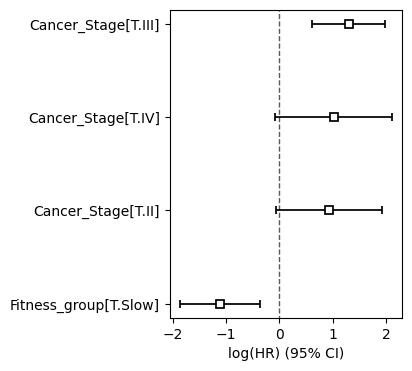

In [8]:
from lifelines import CoxPHFitter,KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines.statistics import logrank_test
cutoff = 0.5
dat = data_df[data_df['tissue_ratio'] >= cutoff ]
dat = dat[dat['Log_Speed'] > 0 ]
#dat = dat[dat['Stage'] < 10 ]

print(dat.shape, dat['Stage'].value_counts())

cph = CoxPHFitter()
cph.fit(data_df, duration_col = 'Overall_Survival', event_col = 'vital.status',formula="Cancer_Stage")
cph.print_summary()

cph = CoxPHFitter()
cph.fit(data_df, duration_col = 'Overall_Survival', event_col = 'vital.status',formula="Sex")
cph.print_summary()

cph = CoxPHFitter()
cph.fit(data_df, duration_col = 'Overall_Survival', event_col = 'vital.status',formula="Speed_group")
cph.print_summary()

cph = CoxPHFitter()
cph.fit(data_df, duration_col = 'Overall_Survival', event_col = 'vital.status',formula="Idx_group")
cph.print_summary()

cph = CoxPHFitter()
cph.fit(data_df, duration_col = 'Overall_Survival', event_col = 'vital.status',formula="Fitness_group")
cph.print_summary()

cph = CoxPHFitter()
cph.fit(dat, duration_col = 'Overall_Survival', event_col = 'vital.status',
        formula="Log_Speed + shannon_index_leiden")
cph.print_summary()

cph = CoxPHFitter()
cph.fit(dat, duration_col = 'Overall_Survival', event_col = 'vital.status',
        formula="Log_Speed")
cph.print_summary()


cph = CoxPHFitter()
cph.fit(dat, duration_col = 'Overall_Survival', event_col = 'vital.status',
        formula="shannon_index_leiden")
cph.print_summary()

cph = CoxPHFitter()
cph.fit(dat, duration_col = 'Overall_Survival', event_col = 'vital.status',
        formula="speed_leiden")
cph.print_summary()

cph = CoxPHFitter()
cph.fit(dat, duration_col = 'Overall_Survival', event_col = 'vital.status',
        formula="Cancer_Stage + Age+Gender + Tobacco.history")
cph.print_summary()


cph = CoxPHFitter()
cph.fit(dat, duration_col = 'Overall_Survival', event_col = 'vital.status',
        formula="Cancer_Stage + Age+Gender + Log_Speed + shannon_index_leiden")
cph.print_summary()

cph = CoxPHFitter()
cph.fit(dat, duration_col = 'Overall_Survival', event_col = 'vital.status',
        formula="Cancer_Stage + Log_Speed + shannon_index_leiden")
cph.print_summary()


cph = CoxPHFitter()
cph.fit(dat, duration_col = 'Overall_Survival', event_col = 'vital.status',
        formula="Cancer_Stage + Speed_group + Idx_group + Age+Gender ")
cph.print_summary()



cph = CoxPHFitter()
cph.fit(dat, duration_col = 'Overall_Survival', event_col = 'vital.status',
        formula="Cancer_Stage + Fitness_group ")
cph.print_summary()




plt.figure(figsize =(3, 4))
cph.plot()
plt.show()

In [34]:
cph = CoxPHFitter()
cph.fit(dat, duration_col = 'Overall_Survival', event_col = 'vital.status',
        formula="Cancer_Stage + Age+Sex ")
cph.print_summary()

cph = CoxPHFitter()
cph.fit(dat, duration_col = 'Overall_Survival', event_col = 'vital.status',
        formula=" Log_Speed + shannon_index_leiden")
cph.print_summary()

cph = CoxPHFitter()
cph.fit(dat, duration_col = 'Overall_Survival', event_col = 'vital.status',
        formula="Cancer_Stage + Age+Sex + Log_Speed + shannon_index_leiden")
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 147 total observations, 103 right-censored observations>
             duration col = 'Overall_Survival'
                event col = 'vital.status'
      baseline estimation = breslow
   number of observations = 147
number of events observed = 44
   partial log-likelihood = -194.89
         time fit was run = 2024-11-21 21:12:33 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
Cancer_Stage[T.II]   0.56      1.75      0.51           -0.43            1.55                0.65                4.70
Cancer_Stage[T.III]  1.55      4.72      0.35            0.87            2.23                2.39                9.33
Cancer_Stage[T.IV]   1.44      4.23      0.56            0.35            2.54                1.42               12.65
Age                  0.01      1.01      0.03           -0.04            0.07                0.96                1.07
Sex[T.Male]          0.41      1.50      0.31           -0.20            1.02                0.82                2.76

                     cmp to    z      p  -log2(p)
covariate                                        
Cancer_Stage[T.II]     0.00 1.10   0.27      1.88
Cancer_Stage[T.III]    0.00 4.47 <0.005     16.94
Cancer_Stage[T.IV]     0.00 2.58   0.01      6.68
Age                    0.00 0.47   0.64      0.64
Sex[T.Male]            0.00 1.30   0.19      2.38
---
Concordance = 0.70
Partial AIC = 399.77
log-likelihood ratio test = 21.82 on 5 df
-log2(p) of ll-ratio test = 10.79

<lifelines.CoxPHFitter: fitted with 147 total observations, 103 right-censored observations>
             duration col = 'Overall_Survival'
                event col = 'vital.status'
      baseline estimation = breslow
   number of observations = 147
number of events observed = 44
   partial log-likelihood = -198.62
         time fit was run = 2024-11-21 21:12:33 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                             
Log_Speed             0.32      1.37      0.14            0.05            0.59                1.05                1.80
shannon_index_leiden  3.56     35.26      1.45            0.71            6.41                2.04              608.27

                      cmp to    z    p  -log2(p)
covariate                                       
Log_Speed               0.00 2.31 0.02      5.57
shannon_index_leiden    0.00 2.45 0.01      6.14
---
Concordance = 0.67
Partial AIC = 401.24
log-likelihood ratio test = 14.36 on 2 df
-log2(p) of ll-ratio test = 10.36

<lifelines.CoxPHFitter: fitted with 147 total observations, 103 right-censored observations>
             duration col = 'Overall_Survival'
                event col = 'vital.status'
      baseline estimation = breslow
   number of observations = 147
number of events observed = 44
   partial log-likelihood = -190.83
         time fit was run = 2024-11-21 21:12:33 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                             
Cancer_Stage[T.II]    0.50      1.65      0.52           -0.51            1.51                0.60                4.54
Cancer_Stage[T.III]   1.28      3.61      0.36            0.58            1.99                1.79                7.30
Cancer_Stage[T.IV]    1.00      2.73      0.57           -0.12            2.13                0.89                8.39
Age                   0.02      1.02      0.03           -0.03            0.08                0.97                1.09
Sex[T.Male]           0.51      1.66      0.32           -0.12            1.13                0.89                3.08
Log_Speed             0.24      1.27      0.14           -0.03            0.52                0.97                1.68
shannon_index_leiden  2.82     16.77      1.53           -0.18            5.81                0.84              335.25

                      cmp to    z      p  -log2(p)
covariate                                         
Cancer_Stage[T.II]      0.00 0.97   0.33      1.59
Cancer_Stage[T.III]     0.00 3.57 <0.005     11.48
Cancer_Stage[T.IV]      0.00 1.75   0.08      3.65
Age                     0.00 0.81   0.42      1.26
Sex[T.Male]             0.00 1.60   0.11      3.18
Log_Speed               0.00 1.73   0.08      3.58
shannon_index_leiden    0.00 1.85   0.07      3.94
---
Concordance = 0.75
Partial AIC = 395.66
log-likelihood ratio test = 29.93 on 7 df
-log2(p) of ll-ratio test = 13.32

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           5.68 0.02      5.87

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          12.28 <0.005     11.09

<lifelines.CoxPHFitter: fitted with 147 total observations, 103 right-censored observations>
             duration col = 'Overall_Survival'
                event col = 'vital.status'
      baseline estimation = breslow
   number of observations = 147
number of events observed = 44
   partial log-likelihood = -194.05
         time fit was run = 2024-11-15 20:21:43 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
Stage         0.21      1.23      0.06            0.09            0.32                1.10                1.38
speed_leiden  0.09      1.09      0.04            0.01            0.16                1.01                1.18

              cmp to    z      p  -log2(p)
covariate                                 
Stage           0.00 3.59 <0.005     11.58
speed_leiden    0.00 2.25   0.02      5.35
---
Concordance = 0.75
Partial AIC = 392.11
log-likelihood ratio test = 23.48 on 2 df
-log2(p) of ll-ratio test = 16.94

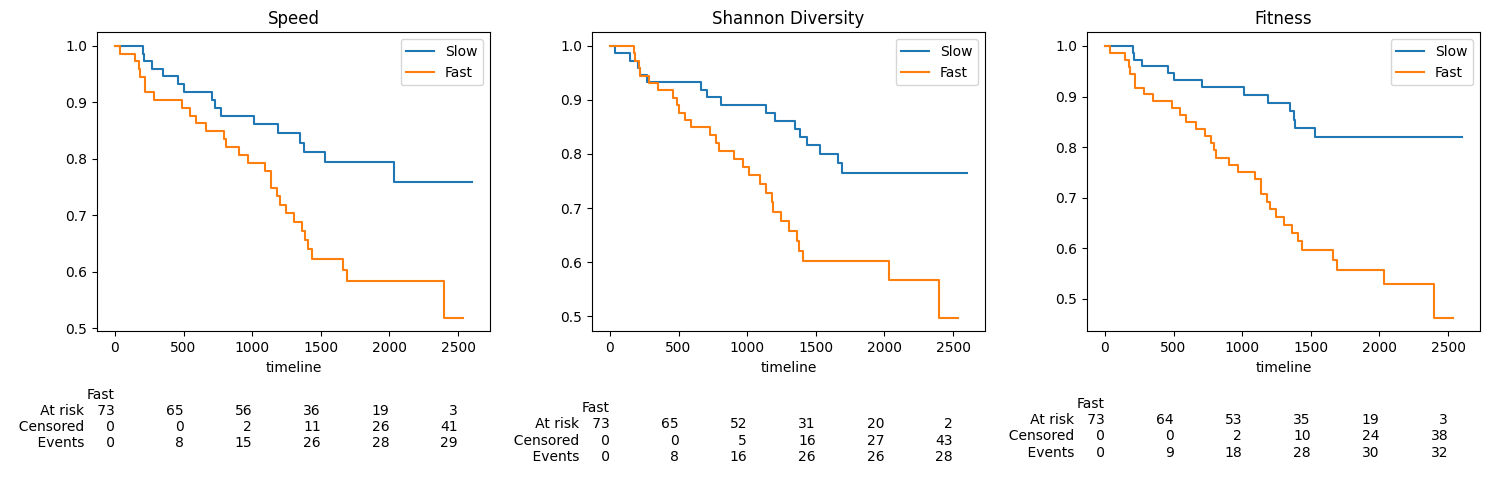

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           6.52 0.01      6.55

In [11]:

plt.figure(figsize =(15, 5))
ax = plt.subplot(131)
kmf = KaplanMeierFitter()
T, E = dat['Overall_Survival'], dat['vital.status']
G =  (dat['Log_Speed'] <= np.median(dat['Log_Speed']))
kmf.fit(durations = T[G], event_observed = E[G], label = "Slow")
kmf.plot_survival_function(ax=ax, at_risk_counts = False, ci_show =False)
kmf.fit(durations = T[-G], event_observed = E[-G], label = "Fast")
kmf.plot_survival_function(ax=ax, at_risk_counts = True,ci_show =False)
#kmf.fit(durations = T, event_observed = E)
#kmf.plot_survival_function(ax=ax, at_risk_counts = True,ci_show =False)
plt.title('Speed')
#plt.show()


results = logrank_test(T[G], T[-G], event_observed_A=E[G], event_observed_B=E[-G])
results.print_summary()

#plt.figure(figsize =(5, 5))
ax = plt.subplot(133)
kmf = KaplanMeierFitter()
T, E = dat['Overall_Survival'], dat['vital.status']
G =  (dat['speed_leiden'] <= np.median(dat['speed_leiden']))
#G =  (data_df['Log_Speed'] <= 8 )
kmf.fit(durations = T[G], event_observed = E[G], label = "Slow")
kmf.plot_survival_function(ax=ax,at_risk_counts = False, ci_show =False)

kmf.fit(durations = T[-G], event_observed = E[-G], label = "Fast")
kmf.plot_survival_function(ax=ax, at_risk_counts = True,ci_show =False)
plt.title('Fitness')
#plt.tight_layout()
#plt.show()

results = logrank_test(T[G], T[-G], event_observed_A=E[G], event_observed_B=E[-G])
results.print_summary()


cph = CoxPHFitter()
cph.fit(dat, duration_col = 'Overall_Survival', event_col = 'vital.status',
        formula="Stage + speed_leiden ")
cph.print_summary()


#plt.figure(figsize =(5, 5))
ax = plt.subplot(132)
kmf = KaplanMeierFitter()
T, E = dat['Overall_Survival'], dat['vital.status']
G =  (dat['shannon_index_leiden'] <= np.median(dat['shannon_index_leiden']))
#G =  (data_df['Log_Speed'] <= 8 )
kmf.fit(durations = T[G], event_observed = E[G], label = "Slow")
kmf.plot_survival_function(ax=ax,at_risk_counts = False, ci_show =False)
kmf.fit(durations = T[-G], event_observed = E[-G], label = "Fast")
kmf.plot_survival_function(ax=ax, at_risk_counts = True, ci_show =False)
plt.title('Shannon Diversity')
plt.show()

results = logrank_test(T[G], T[-G], event_observed_A=E[G], event_observed_B=E[-G])
results.print_summary()


0.18304611628061992


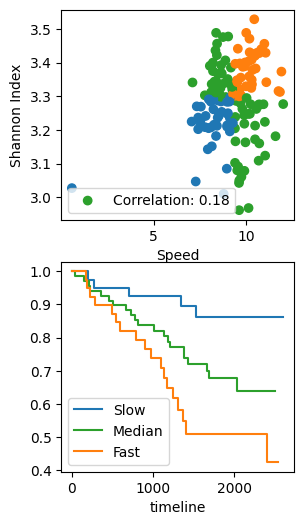

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          11.53 <0.005     10.51

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           2.96 0.09      3.55

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.35 0.04      4.76

In [13]:


correlation = np.corrcoef(dat['Log_Speed'], dat['shannon_index_leiden'])[0, 1]
print(correlation)

slow =  ((dat['shannon_index_leiden'] <= np.median(dat['shannon_index_leiden'])) & (dat['Log_Speed'] <= np.median(dat['Log_Speed'])))
median_fast = ((dat['shannon_index_leiden'] > np.median(dat['shannon_index_leiden'])) & (dat['Log_Speed'] <= np.median(dat['Log_Speed'])))
fast =  ((dat['shannon_index_leiden'] > np.median(dat['shannon_index_leiden'])) & (dat['Log_Speed'] > np.median(dat['Log_Speed'])))
median_slow = ((dat['shannon_index_leiden'] <= np.median(dat['shannon_index_leiden'])) & (dat['Log_Speed'] > np.median(dat['Log_Speed'])))

dat['colors'] = '#2ca02c'
dat.loc[slow,'colors'] = '#1f77b4'
dat.loc[fast,'colors'] = '#ff7f0e'
#print (dat['colors'])

plt.figure(figsize=(3,6))
plt.subplot(211)
#plt.scatter(dat['Log_Speed'],dat['shannon_index_leiden'], color='b', label=f'Correlation: {correlation:.2f}')
plt.scatter(dat['Log_Speed'],dat['shannon_index_leiden'], c=dat['colors'], label=f'Correlation: {correlation:.2f}')
#plt.title('Speed vs Shannon Index')
plt.xlabel('Speed')
plt.ylabel('Shannon Index')
plt.legend()
plt.grid(False)
#plt.show()


#plt.figure(figsize =(5, 5))
ax = plt.subplot(212)
kmf = KaplanMeierFitter()
T, E = dat['Overall_Survival'], dat['vital.status']
kmf.fit(durations = T[slow], event_observed = E[slow], label = "Slow")
kmf.plot_survival_function(ax=ax, ci_show =False,color='#1f77b4')

kmf.fit(durations = T[median_slow + median_fast], event_observed = E[median_slow+median_fast], label = "Median")
kmf.plot_survival_function(ax=ax, ci_show =False,color='#2ca02c')

#kmf.fit(durations = T[median_fast], event_observed = E[median_fast], label = "median Fast")
#kmf.plot_survival_function(ax=ax, ci_show =False)

kmf.fit(durations = T[fast], event_observed = E[fast], label = "Fast")
kmf.plot_survival_function(ax=ax, ci_show =False,color='#ff7f0e')

plt.show()

results = logrank_test(T[slow], T[fast], event_observed_A=E[slow], event_observed_B=E[fast])
results.print_summary()

results = logrank_test(T[median_slow + median_fast], T[fast], event_observed_A=E[median_slow + median_fast], event_observed_B=E[fast])
results.print_summary()

results = logrank_test(T[median_slow + median_fast], T[slow], event_observed_A=E[median_slow + median_fast], event_observed_B=E[slow])
results.print_summary()


